In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax

始める前に表記について説明します。今回は次の表記を使っていきます。
* $(\pi Q)(x):=\sum_{a \in \mathbf{A}} \pi(a \mid x) Q(x, a)$
* $(\mathcal{P} V)(x, a):=\sum_{y \in \mathbf{X}} \mathcal{P}(y \mid x, a) V(y)$

また、$\pi_Q \in G(Q)$をQについての貪欲方策とし、$\mathcal{T}^{\pi}Q :=r + \gamma\mathcal{P}^\pi Q$、$\mathcal{T}Q :=r + \gamma\mathcal{P}^{\pi_Q} Q$とします。
他のNotationは[論文](https://arxiv.org/abs/2103.00107)と雰囲気に任せます。

# マルチステップ強化学習

参考
* [Revisiting Peng's Q(λ) for Modern Reinforcement Learning](https://arxiv.org/abs/2103.00107)

強化学習の基本は``推定``と``制御``にあります。
RLアルゴリズムは「推定と制御で何ステップ分の情報を使うか？」で一般化することができます。
今回は一般的なアルゴリズムをいくつか確認していきましょう。

まず、一番基本であるValue Iterationアルゴリズムを確認します。

--- 

**Value Iteration (VI)**

* 推定: $Q_{k+1} := r + \mathcal{P}^{\pi_k} Q_k$
* 制御: $\pi_{k+1} := \pi_{Q_{k+1}}$
* ベルマン作用素: $\mathcal{T}^\pi Q := r + \gamma \mathcal{P}^\pi Q$

これは「1ステップの貪欲方策」と「1ステップの推定」をしていると考えることができます。

---

マルチステップのアルゴリズムを見ていきましょう。
まずは推定についてマルチステップなアルゴリズムを見ていきます。

## マルチステップ推定

### On-policyのアルゴリズム

---
**Modified Policy Iteration (MPI)** 
* 参考文献: [Modified Policy Iteration Algorithms for Discounted Markov Decision Problems](https://www.jstor.org/stable/2630487)

MPIは価値反復法の一般化です。$n$-ステップ推定をします。$n=1$ならVIと同じです。

* 推定: $Q_{k+1} := \left(\mathcal{T}^{\pi_{k}}\right)^n Q_k = r + \mathcal{P}^{\pi_k} \left(r + \mathcal{P}^{\pi_k} + \left(\dots + \left(r + \mathcal{P}^{\pi_k} Q_k\right)\right)\right)$
* 制御: $\pi_{k+1} := \pi_{Q_{k+1}}$
* ベルマン作用素: $\mathcal{T}_n^\pi := \left(\mathcal{T}^{\pi}\right)^n Q$

---

---
**$\lambda$-Policy Iteration ($\lambda$-PI)**
* 参考文献: [Temporal Differences-Based Policy Iteration and Applications in Neuro-Dynamic Programming](https://web.mit.edu/dimitrib/www/Tempdif.pdf)

$\lambda$-PIはMPIの一般化です。$[1 \dots \infty]$-ステップ推定を$\lambda$で重み付けして混ぜます。
* 推定: $Q_{k+1} := (1 - \lambda)\sum^\infty_{n=1}\lambda^{n-1}\mathcal{T}^{\pi_k}_n Q_k$
* 制御: $\pi_{k+1} := \pi_{Q_{k+1}}$
* ベルマン作用素: $\mathcal{T}^\pi_\lambda := (1 - \lambda)\sum^\infty_{n=1}\lambda^{n-1}\mathcal{T}^{\pi}_n Q = Q + (I - \gamma \lambda \mathcal{P}^\pi)^{-1} (\mathcal{T}^\pi Q - Q)$

---

先にOn-policyのアルゴリズムをPythonで確認してみましょう。
まずMDPを作ります。

In [2]:
from typing import Optional, NamedTuple

def create_rew_P(S: int, A: int):
    """ テーブルMDP (報酬関数, 遷移確率) を作成します

    Args:
        S (int): 状態空間のサイズ
        A (int): 行動空間のサイズ

    Returns:
        rew (float): 報酬関数
        P (float): 遷移確率
    """
    rew = np.random.rand(S, A)  # ランダムな報酬関数。実験のために0~1に正規化します。
    rew = rew / np.abs(rew).max()

    # ランダムな遷移確率を作ります
    P = np.random.rand(S, A, S)
    P = P / np.sum(P, axis=-1, keepdims=True)  # 正規化して確率にします
    assert P.shape == (S, A, S)
    np.testing.assert_almost_equal(P.sum(axis=-1), 1)

    return jnp.array(rew), jnp.array(P)

class MDP(NamedTuple):
    S_array: np.array  # 状態空間
    A_array: np.array  # 行動空間
    gamma: float  # 割引率
    horizon: int  # ホライゾン
    rew: float  # 報酬関数
    P: float  # 遷移確率
    optimal_Q: Optional[np.ndarray] = None  # 最適Q値
    optimal_Q_idx: Optional[np.ndarray] = None  # 後でplot用に使います

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_array)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_array)


S = 10
A = 2
S_array = np.arange(S)
A_array = np.arange(A)
gamma = 0.99
horizon = int(1 / (1 - gamma))

# テーブルMDPを作ります
t_rew, t_P = create_rew_P(S, A)
table_MDP = MDP(S_array, A_array, gamma, horizon, t_rew, t_P)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


実験の前に、いくつか便利な関数を導入します。

1. ``compute_greedy_policy``: Q関数 ($S \times A \to \mathcal{R}$) の貪欲方策を返します
2. ``compute_optimal_Q``: MDPの最適Q関数 $q_* : S \times A \to \mathcal{R}$ を返します。
3. ``compute_policy_Q``: 方策 $\pi$ のQ関数 $q_\pi : S \times A \to \mathcal{R}$ を返します。
4. ``compute_optimality_gap``: 方策 $\pi$ と最適解との差 $\|q_* - q_{\pi}\|_\infty$ を返します。この値が小さいほど、$\pi$ はほぼ全ての状態行動対で最適な方策になっています。
5. ``compute_Ppi``: 方策$\pi$の元での遷移行列$\mathcal{P}^{\pi}$を返します。[これ](http://proceedings.mlr.press/v28/pirotta13.pdf)の２ページ目を参考にしてください

In [4]:
from functools import partial


# >>>> 1 >>>>
@jax.jit
def compute_greedy_policy(Q: np.ndarray):
    greedy_policy = jnp.zeros_like(Q)
    S, A = Q.shape
    greedy_policy = greedy_policy.at[jnp.arange(S), Q.argmax(axis=1)].set(1)
    assert greedy_policy.shape == (S, A)
    return greedy_policy
# <<<< 1 <<<<


# >>>> 2 >>>>
@partial(jax.jit, static_argnames=("S", "A"))
def _compute_optimal_Q(mdp: MDP, S: int, A: int):

    def backup(optimal_Q):
        greedy_policy = compute_greedy_policy(optimal_Q)
        max_Q = (greedy_policy * optimal_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon + 1000, body_fn, optimal_Q)

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.S, mdp.A)
# <<<< 2 <<<<


# >>>> 3 >>>>
def compute_policy_Q(mdp: MDP, policy: np.ndarray):
    S, A = policy.shape

    def backup(policy_Q):
        max_Q = (policy * policy_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    policy_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon + 1000, body_fn, policy_Q)
# <<<< 3 <<<<

# >>>> 4 >>>>
@jax.jit
def compute_optimality_gap(mdp: MDP, policy: np.ndarray):
    policy_Q = compute_policy_Q(mdp, policy)
    optimality_gap = jnp.abs(mdp.optimal_Q - policy_Q).max()
    return optimality_gap
# <<<< 4 <<<<


# >>>> 5 >>>>
@jax.jit
def compute_Ppi(mdp: MDP, policy: np.ndarray):
    P = mdp.P.reshape(S*A, S)
    PI = jnp.zeros((S, S, A))
    for s in range(S):
        PI = PI.at[s, s].set(policy[s])
    PI = PI.reshape(S, S*A)
    Ppi = P @ PI
    assert Ppi.shape == (S*A, S*A)
    return Ppi
# <<<< 5 <<<<

table_MDP = table_MDP._replace(optimal_Q=compute_optimal_Q(table_MDP))

## On-policyアルゴリズムの実験

さっそくOn-policyアルゴリズムの実験をしてみます。
それぞれIterationの回数で比較していますが、これはあんまりフェアではありません。MPIの$n$が大きくなるほど計算量が増えるためであり、また、そもそも$\lambda$-PIの解析回は無限和を使っています。

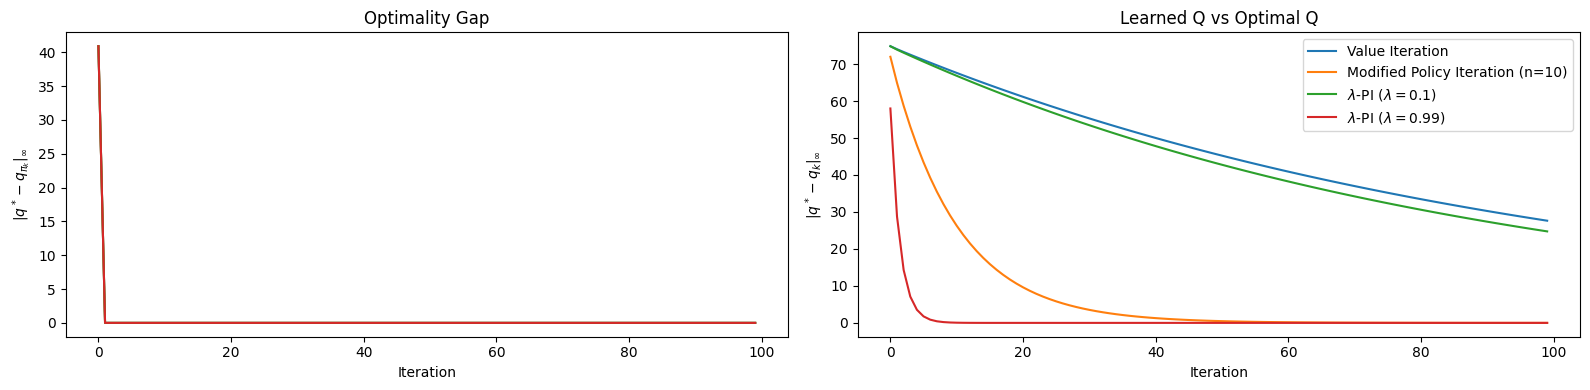

In [7]:
@partial(jax.jit, static_argnames=("n_step"))
def n_step_evaluate(mdp: MDP, Q: np.ndarray, policy: np.ndarray, n_step: int):
    # n-step 推定をします
    S, A = Q.shape
    for i in range(n_step):
        Q_pi = np.sum(policy * Q, axis=1).reshape(1, 1, S)
        next_v = np.sum(mdp.P * Q_pi, axis=-1)
        assert next_v.shape == (S, A)
        Q = mdp.rew + mdp.gamma * next_v
        assert Q.shape == (S, A)
    return Q


@partial(jax.jit)
def lambda_evaluate(mdp: MDP, Q: np.ndarray, policy: np.ndarray, lam: float):
    # lambda-PIの推定ステップをします
    S, A = Q.shape
    TQ = n_step_evaluate(mdp, Q, policy, 1)
    Ppi = compute_Ppi(mdp, policy)
    return Q + (jnp.linalg.inv(jnp.eye(S*A) - gamma * lam * Ppi) @ (TQ - Q).reshape(S*A)).reshape(S, A)



def do_table_value_iteration(mdp: MDP, n_step: int, lam: float, iteration: int):
    optimality_gaps = []
    Q_gaps = []
    
    # >>>> Do value iteration >>>>
    Q_table = np.zeros((mdp.S, mdp.A))
    for i in range(iteration):
        greedy_policy = compute_greedy_policy(Q_table)
        if lam is None:
            Q_table = n_step_evaluate(mdp, Q_table, greedy_policy, n_step)
        elif n_step is None:
            Q_table = lambda_evaluate(mdp, Q_table, greedy_policy, lam)
        optimality_gaps.append(compute_optimality_gap(mdp, greedy_policy))
        Q_gaps.append(np.abs(Q_table - mdp.optimal_Q).max())
    # <<<< Do value iteration <<<<

    return optimality_gaps, Q_gaps

VI_opt, VI_q = do_table_value_iteration(table_MDP, 1, None, 100)
MPI_opt, MPI_q = do_table_value_iteration(table_MDP, 10, None, 100)
lam01_opt, lam01_q = do_table_value_iteration(table_MDP, None, 0.1, 100)
lam099_opt, lam099_q = do_table_value_iteration(table_MDP, None, 0.99, 100)


plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(VI_opt, label="Value Iteration")
plt.plot(MPI_opt, label="Modified Policy Iteration (n=10)")
plt.plot(lam01_opt, label=r"$\lambda$-PI ($\lambda=0.1$)")
plt.plot(lam099_opt, label=r"$\lambda$-PI ($\lambda=0.99$)")
plt.xlabel("Iteration")
plt.ylabel(r"$\|q^* - q_{\pi_k}\|_\infty$")
plt.title("Optimality Gap")

plt.subplot(1, 2, 2)
plt.plot(VI_q, label="Value Iteration")
plt.plot(MPI_q, label="Modified Policy Iteration (n=10)")
plt.plot(lam01_q, label=r"$\lambda$-PI ($\lambda=0.1$)")
plt.plot(lam099_q, label=r"$\lambda$-PI ($\lambda=0.99$)")
plt.xlabel("Iteration")
plt.ylabel(r"$\|q^* - q_{k}\|_\infty$")
plt.title("Learned Q vs Optimal Q")
# <<<< Plot results <<<<

plt.tight_layout()
plt.legend()

### Off-policyのアルゴリズム

On-policyのアルゴリズムでは推定で$r + \mathcal{P}^{\pi_k}(r + \dots)$が登場していました。
しかし、これはいつでもできるわけではありません。Off-policyでは別の方策で代替します。

### Traceによる補正をしないアルゴリズム

On-policyのアルゴリズムをそのままOff-policyにするとBehavior方策とTarget方策間の差異による問題が発生します。
これを補正するために、Trajectoryの計算中に補正用の係数 (trace) をかけることがあります。
一方で、方策の補正が面倒くさいのでしないアルゴリズムも存在しています。先にそっちを見てみましょう。

---
**Uncorrected $n$-step Return** 
* 参考文献: [Rainbow: Combining Improvements in Deep Reinforcement Learning](https://arxiv.org/abs/1710.02298)
* 参考文献: [Recurrent experience replay in distributed reinforcement learning](https://www.deepmind.com/publications/recurrent-experience-replay-in-distributed-reinforcement-learning)

MPIはOn-policyな更新でした。これはOff-policyアルゴリズムでは使うのが難しいので、RainbowやR2D2では次のOff-policy版を使っています。

* 推定: $Q_{k+1} := \left(\mathcal{T}^{\mu_k}\right)^{n-1} \mathcal{T}^{\pi_k}Q_k = r + \mathcal{P}^{\mu_k} \left(r + \mathcal{P}^{\mu_k} + \left(\dots + \left(r + \mathcal{P}^{\pi_k} Q_k\right)\right)\right)$
* 制御: $\pi_{k+1} := \pi_{Q_{k+1}}$
* ベルマン作用素: $\mathcal{N}_n^{\mu, \pi} := \left(\mathcal{T}^{\mu}\right)^{n-1} \mathcal{T}^\pi Q$

---

---
**Peng's $Q(\lambda)$ (PQL)** 
* 参考文献: [Incremental multi-step Q-learning](https://link.springer.com/article/10.1007/BF00114731)

PQLは$\lambda$-PIのOff-policyバージョンです。

* 推定: $Q_{k+1} := (1 - \lambda)\sum^\infty_{n=1}\lambda^{n-1}\mathcal{N}^{\mu_k, \pi_k}_n Q_k$
* 制御: $\pi_{k+1} := \pi_{Q_{k+1}}$
* ベルマン作用素: $\mathcal{N}^{\mu, \pi}_\lambda := (1 - \lambda)\sum^\infty_{n=1}\lambda^{n-1}\mathcal{N}^{\mu, \pi}_n Q$

---

最後に、補正を含めた一般的なアルゴリズムを確認してみます。

---

**General Retrace**

* 参考文献: [Revisiting Peng's Q(λ) for Modern Reinforcement Learning](https://arxiv.org/abs/2103.00107)

General RetraceはPQLに補正項を追加したものです。
補正項を導入するために、次の遷移カーネルを導入します：

$$\left(\mathcal{P}^{c \mu} Q\right)(x, a):=\sum_{(y, b) \in \mathbf{X} \times \mathbf{A}} \mathcal{P}(y \mid x, a) c(y, b) \mu(b \mid y) Q(y, b)$$

これを使ってGeneral Retraceは次で推定と制御をします。

* 推定: $Q_{k+1} := \mathcal{R}_{\lambda}^{c_k \mu_k, \pi_k} Q_k$
* 制御: $\pi_{k+1} := \pi_{Q_{k+1}}$
* ベルマン作用素: $\mathcal{R}_{\lambda}^{c \mu, \pi} Q:=Q+\left(\mathcal{I}-\gamma \lambda \mathcal{P}^{c \mu}\right)^{-1}\left(\mathcal{T}^{\pi} Q-Q\right) .
$

ここで、$Q_k$は
$$
Q_{k}\left(x_{0}, a_{0}\right)+\sum_{t=0}^{\infty}\left(\prod_{u=1}^{t} c\left(x_{u}, a_{u}\right)\right) \gamma^{t} \lambda^{t} \delta_{t}
$$
の形で書き直せます。$\delta_t$はTD誤差です。これはつまり、Off-policyなTD誤差を$\prod_{u=1}^{t} c\left(x_{u}, a_{u}\right)$ で補正しているとみなせます。この補正項$\prod_{u=1}^{t} c\left(x_{u}, a_{u}\right)$がtraceと呼ばれます。

$c_k$の設計次第で様々なアルゴリズムが復元されます。$\rho_k = \pi_k / \mu_k$, $\widetilde{\rho}_k = (1 - \alpha) + \alpha \pi_{Q_k}$として、下の表を参考にしてください (参考文献のTable 2と同じですが、論文では$\lambda$と$1-\lambda$が逆になってます)。

| Algorithm     | $c_{k}$                                       | $\pi_{k}$                                 |
|----------------------|-----------------------------------------------|-------------------------------------------|
| $\alpha$-TRACE | $\min \left\{1, \widetilde{\rho}_{k}\right\}$ | $(1-\alpha) \pi_{Q_{k}}+\alpha \mu_{k}$   |
| C-TRACE              | $\min \left\{1, \widetilde{\rho}_{k}\right\}$ | $(1-\alpha) \pi_{Q_{k}}+\alpha \mu_{k}$   |
| HQL                  | 1                                             | $\pi_{Q_{k}}$                             |
| RETRACE              | $\min \left\{1, \rho_{k}\right\}$             | $\mathrm{ANY}$                            |
| TBL                  | $\pi_{k}$                                     | $\mathrm{ANY}$                            |
| $\mathrm{WQL}$       | $\min \left\{1, \rho_{k}\right\}$             | $\pi_{Q_{k}}$                             |
| PQL                  | 1                                             | $(1-\lambda) \pi_{Q_{k}}+\lambda \mu_{k}$ |


---

## Off-policyアルゴリズムの実験

Off-policyアルゴリズムの実験をしてみましょう。
様々な$c_k$や$\pi_k$でGeneral Retraceの挙動を観察してみます。

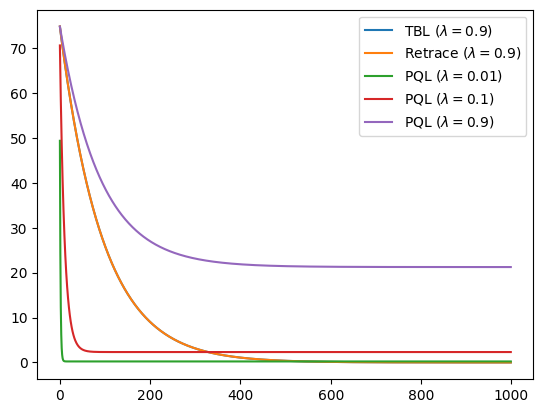

In [8]:
@partial(jax.jit)
def lambda_evaluate(mdp: MDP, Q: np.ndarray, policy: np.ndarray, c_k: np.ndarray, behavior_policy: np.ndarray, lam: float):
    # lambda-PIの推定ステップをします
    S, A = Q.shape
    TQ = n_step_evaluate(mdp, Q, policy, 1)
    Ppi = compute_Ppi(mdp, c_k * behavior_policy)
    return Q + (jnp.linalg.inv(jnp.eye(S*A) - gamma * (1-lam) * Ppi) @ (TQ - Q).reshape(S*A)).reshape(S, A)


def do_table_value_iteration(mdp: MDP, lam: float, c_type: str, iteration: int):
    optimality_gaps = []
    Q_gaps = []
    
    # Initialize Q
    Q_table = np.zeros((mdp.S, mdp.A))

    # Behavior policy
    behavior_policy = np.ones_like(Q_table)  # 一様分布です
    behavior_policy = behavior_policy / behavior_policy.sum(axis=1, keepdims=True)

    # >>>> Do value iteration >>>>
    for i in range(iteration):
        greedy_policy = compute_greedy_policy(Q_table)

        # c_kを計算し、pi_kも計算します
        if c_type == "TBL":
            c_k = greedy_policy
            policy = greedy_policy

        elif c_type == "PQL":
            c_k = 1
            policy = (1-lam) * greedy_policy + lam * behavior_policy

        elif c_type == "Retrace":
            c_k = np.minimum(1, greedy_policy / behavior_policy)
            policy = greedy_policy

        Q_table = lambda_evaluate(mdp, Q_table, policy, c_k, behavior_policy, lam)
        optimality_gaps.append(compute_optimality_gap(mdp, policy))
        Q_gaps.append(np.abs(Q_table - mdp.optimal_Q).max())
    # <<<< Do value iteration <<<<
    return Q_gaps

lam = 0.9
iteration = 1000
res_TBL = do_table_value_iteration(table_MDP, lam, "TBL", iteration)
res_PQL_09 = do_table_value_iteration(table_MDP, lam, "PQL", iteration)
res_Retrace = do_table_value_iteration(table_MDP, lam, "Retrace", iteration)
res_PQL_01 = do_table_value_iteration(table_MDP, 0.1, "PQL", iteration)
res_PQL_001 = do_table_value_iteration(table_MDP, 0.01, "PQL", iteration)

plt.plot(res_TBL, label=r"TBL ($\lambda = 0.9$)")
plt.plot(res_Retrace, label=r"Retrace ($\lambda = 0.9$)")
plt.plot(res_PQL_001, label=r"PQL ($\lambda = 0.01$)")
plt.plot(res_PQL_01, label=r"PQL ($\lambda = 0.1$)")
plt.plot(res_PQL_09, label=r"PQL ($\lambda = 0.9$)")
plt.legend()

結果から何が分かるでしょうか？

TBLとRetraceのような補正をするアルゴリズムがちゃんと収束していることがわかります。この２つが$Q_\pi$と$Q_*$に収束することは原著で証明されています。

一方で、PQLは$\lambda$の値次第では収束ができていません。これは[Revisiting Peng's Q(λ) for Modern Reinforcement Learning](https://arxiv.org/abs/2103.00107)で証明されてますが、PQLは$Q^{\lambda \mu+(1-\lambda) \pi_{\dagger}}$に収束します。
ここで、$\pi_\dagger$は任意の$\pi$で$Q^{\lambda \mu+(1-\lambda) \pi_{\dagger}} \geq Q^{\lambda \mu+(1-\lambda) \pi}$を満たす方策です。
つまり、$\lambda$の値が$1$に近いほど学習する$Q$値にバイアスが乗ります。

## マルチステップ制御

これまでのアルゴリズムでは１ステップについて貪欲な方策を考えていましたが、必ずしもこれは１ステップである必要がありません。
例えばMonte Carlo木探索やモデル予測制御は複数ステップについて貪欲な方策を吐き出しています。
ここからはマルチステップな制御を行うアルゴリズムを見ていきましょう。


### On-policyのアルゴリズム

---
**$h$-Greedy policy** 

* 参考文献: [Multiple-Step Greedy Policies in Online and Approximate Reinforcement Learning](https://arxiv.org/abs/1805.07956)

$h$-貪欲方策では$h$ステップだけ貪欲な方策を考えます。つまり、$h=1$ならVIと同じです。
推定の方は省略します。
次の方策集合$\mathcal{G}_h$の要素を$h$-貪欲方策と呼びます。

* 準備: $\forall v, \pi, T_{h}^{\pi} v \stackrel{\text { def }}{=} T^{\pi} T^{h-1} v$
* 制御: $\forall v, \mathcal{G}_{h}(v) =\left\{\pi: T_{h}^{\pi} v=T^{h} v\right\}$

---

---

**$\kappa$-Greedy policy** 

$\lambda$-PIは無限ステップの重み付き推定を考えていましたが、同様にして無限ステップの重み付き貪欲方策も考えることができます。

次の方策集合の要素を$\kappa$-貪欲方策と呼びます。

* 準備: $\forall v, \pi, T_{\kappa}^{\pi} v \stackrel{\text { def }}{=}(1-\kappa) \sum_{j=0}^{\infty} \kappa^{j}\left(T^{\pi}\right)^{j+1} v$
* 制御: $\forall v, \mathcal{G}_{\kappa}(v)=\left\{\pi: T_{\kappa}^{\pi} v=T_{\kappa} v\right\}$

また、$\kappa$-貪欲方策では次が成立します。
$$
\forall v, \pi, T_{\kappa}^{\pi} v =\left(I-\kappa \gamma P^{\pi}\right)^{-1}\left(r^{\pi}+(1-\kappa) \gamma P^{\pi} v\right) 
$$

これを$v^{*}=\left(I-\gamma P^{\pi^{*}}\right)^{-1} r^{\pi^{*}}$と比較すると、$\kappa$-貪欲方策は「割引率が$\kappa\gamma$かつ報酬関数が$\hat{r}^{\pi, v} \stackrel{\text { def }}{=} r^{\pi}+(1-\kappa) \gamma P^{\pi} v$で定義されたMDP (Surrogate MDP) の最適方策」と一致することがわかります。

---

さっそく実験してみましょう。

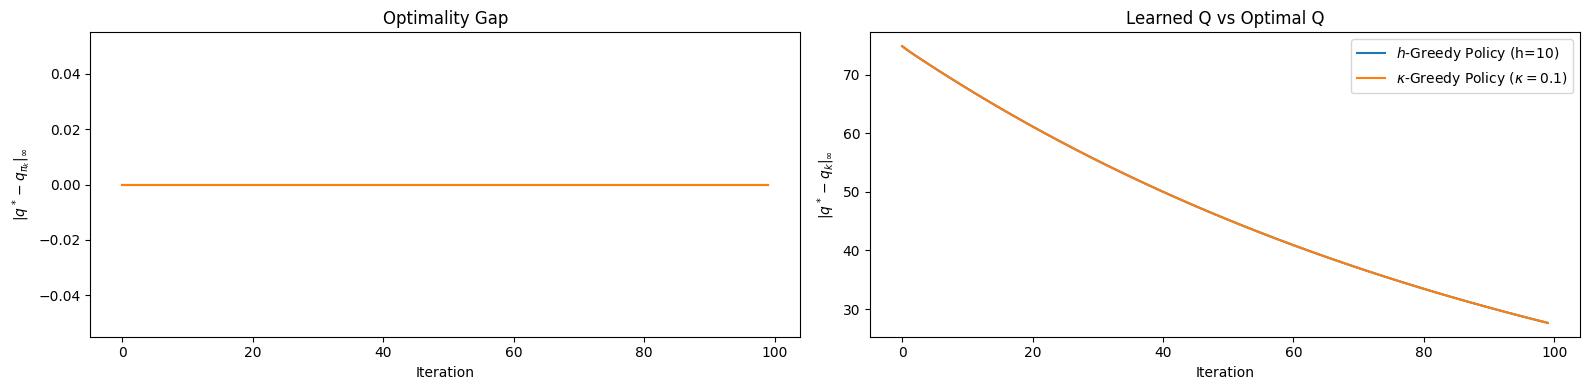

In [9]:
@partial(jax.jit, static_argnames=("h_step"))
def h_step_control(mdp: MDP, Q: np.ndarray, h_step: int):
    # n-step 制御をします
    S, A = Q.shape
    for i in range(h_step-1):
        Q_max = Q.max(axis=1).reshape(1, 1, S)
        next_v = np.sum(mdp.P * Q_max, axis=-1)
        assert next_v.shape == (S, A)
        Q = mdp.rew + mdp.gamma * next_v
        assert Q.shape == (S, A)
    h_step_greedy_policy = compute_greedy_policy(Q)
    return h_step_greedy_policy


@partial(jax.jit)
def kappa_control(mdp: MDP, Q: np.ndarray, kappa: float):
    # kappa-貪欲方策を計算します。
    S, A = Q.shape
    max_Q = Q.max(axis=-1)
    rew = mdp.rew + (1 - kappa) * mdp.gamma * mdp.P @ max_Q

    # surrogate MDPの最適Qを計算します。
    def backup(optimal_Q):
        max_Q = optimal_Q.max(axis=-1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return rew + mdp.gamma * kappa * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    optimal_Q = jax.lax.fori_loop(0, mdp.horizon + 1000, body_fn, optimal_Q)

    # 貪欲方策を返します
    return compute_greedy_policy(optimal_Q)



def do_table_value_iteration(mdp: MDP, h_step: int, kappa: float, iteration: int):
    optimality_gaps = []
    Q_gaps = []
    
    # >>>> Do value iteration >>>>
    Q_table = np.zeros((mdp.S, mdp.A))
    for i in range(iteration):
        if kappa is None:
            greedy_policy = h_step_control(mdp, Q_table, h_step)
        elif h_step is None:
            greedy_policy = kappa_control(mdp, Q_table, kappa)
        Q_table = n_step_evaluate(mdp, Q_table, greedy_policy, 1)
        optimality_gaps.append(compute_optimality_gap(mdp, greedy_policy))
        Q_gaps.append(np.abs(Q_table - mdp.optimal_Q).max())
    # <<<< Do value iteration <<<<
    return optimality_gaps, Q_gaps 

h_opt, h_q = do_table_value_iteration(table_MDP, 10, None, 100)
kap_opt, kap_q = do_table_value_iteration(table_MDP, None, 0.1, 100)


plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(h_opt, label=r"$h$-Greedy Policy (h=10)")
plt.plot(kap_opt, label=r"$\kappa$-Greedy Policy ($\kappa=0.1$)")
plt.xlabel("Iteration")
plt.ylabel(r"$\|q^* - q_{\pi_k}\|_\infty$")
plt.title("Optimality Gap")

plt.subplot(1, 2, 2)
plt.plot(h_q, label=r"$h$-Greedy Policy (h=10)")
plt.plot(kap_q, label=r"$\kappa$-Greedy Policy ($\kappa=0.1$)")
plt.xlabel("Iteration")
plt.ylabel(r"$\|q^* - q_{k}\|_\infty$")
plt.title("Learned Q vs Optimal Q")

plt.tight_layout()
plt.legend()

MDPが小さすぎてあんまり差が出ないですね。まあ実装がわかったのでOKとします。
重要な性質: 「$\kappa$-貪欲方策と$\lambda$-推定は、どちらもちゃんと最適方策への収束が保証されています」